In [1]:
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

In [2]:
exp_name = "200903_uci"

In [13]:
def plot_grid(runs, y, yerr=None, ylabel="performance", ylim=None, title=None):
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    fig, axes = plt.subplots(len(scales), len(temps), sharex=True, sharey=True, figsize=(10,10))

    for scale, axs in zip(scales, axes):
        for temp, ax in zip(temps, axs):
            df = runs.sort_values(["weight_prior", "weight_scale"]).query(f"weight_scale == {scale} & temperature == {temp}")
            df.plot(x="weight_prior", y=y, yerr=yerr, kind="bar", legend=False, ax=ax)
            ax.set_title(f"scale={scale} and T={temp}")
            ax.set_ylabel(ylabel)
            if ylim is not None:
                ax.set_ylim(ylim)
    if title is not None:
        fig.suptitle(title)

    if title is not None:
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [5]:
runs = []
for config_file in glob(f"../results/{exp_name}/*/config.json"):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    runs.append(run_data)
runs_all = pd.concat(runs, axis=1).T

In [6]:
runs_all.head()

,batch_size,batchnorm,bias_loc,bias_prior,bias_scale,burnin,cycles,data,device,inference,...,weight_loc,weight_prior,weight_scale,width,acc_mean,acc_std,acc_stderr,lp_mean,lp_std,lp_stderr
0,None,True,0,gaussian,1,1000,20,UCI_wine,try_cuda,SGLD,...,0,gaussian_uniform,1.41,50,NaN,NaN,NaN,NaN,NaN,NaN
1,None,True,0,gaussian,1,1000,20,UCI_power,try_cuda,SGLD,...,0,laplace,0.14,50,0.0661063,0.000637168,6.37168e-05,-0.0613095,2.05089,0.0662959
2,None,True,0,gaussian,1,1000,20,UCI_yacht,try_cuda,SGLD,...,0,gaussian,0.14,50,1.03143,7.09684e-05,7.09684e-06,-1.4382,1.14377,0.205426
3,None,True,0,gaussian,1,1000,20,UCI_energy,try_cuda,SGLD,...,0,improper,0.14,50,NaN,NaN,NaN,NaN,NaN,NaN
4,None,True,0,gaussian,1,1000,20,UCI_power,try_cuda,SGLD,...,0,gaussian_gamma,14.1,50,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
datasets = sorted(runs_all.data.unique())

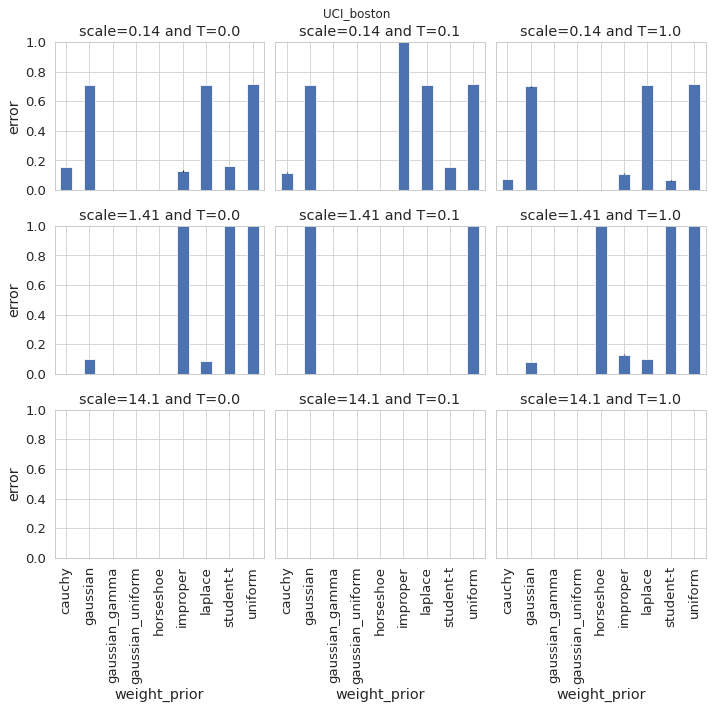

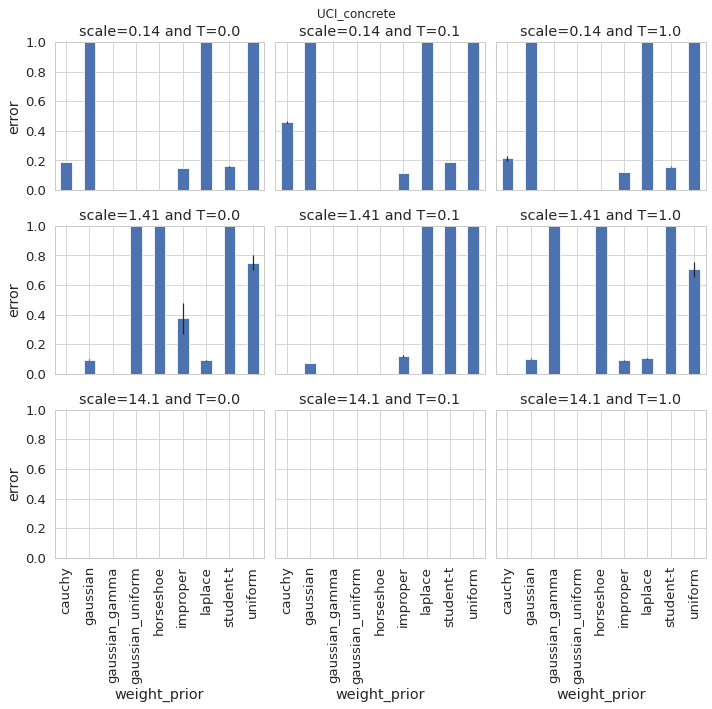

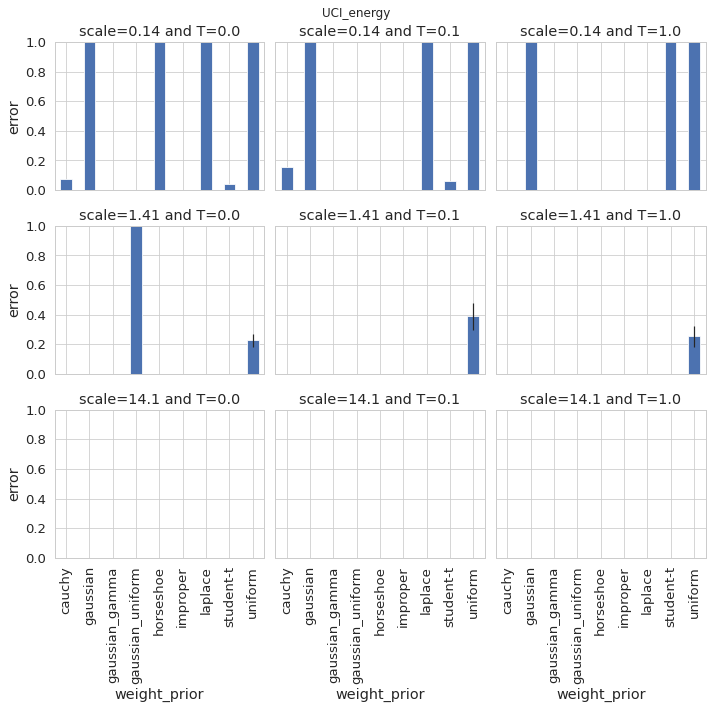

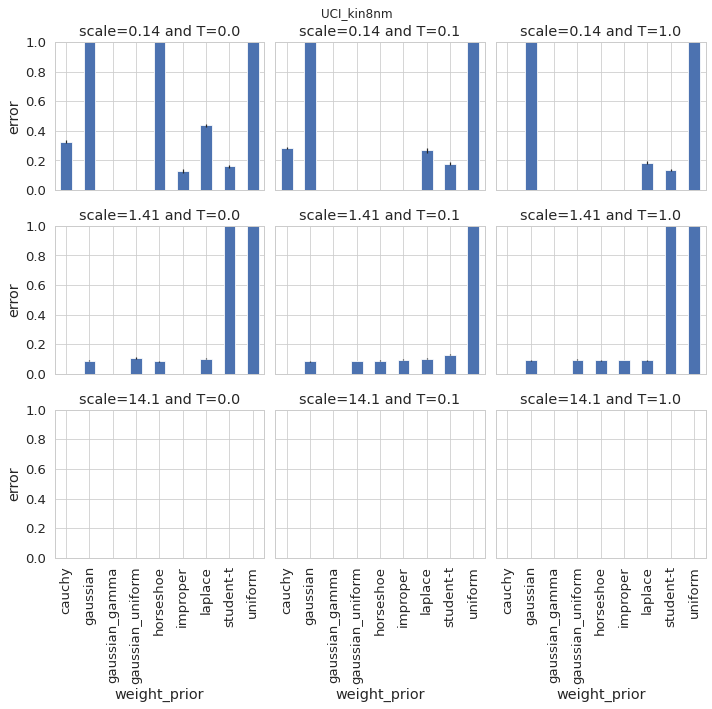

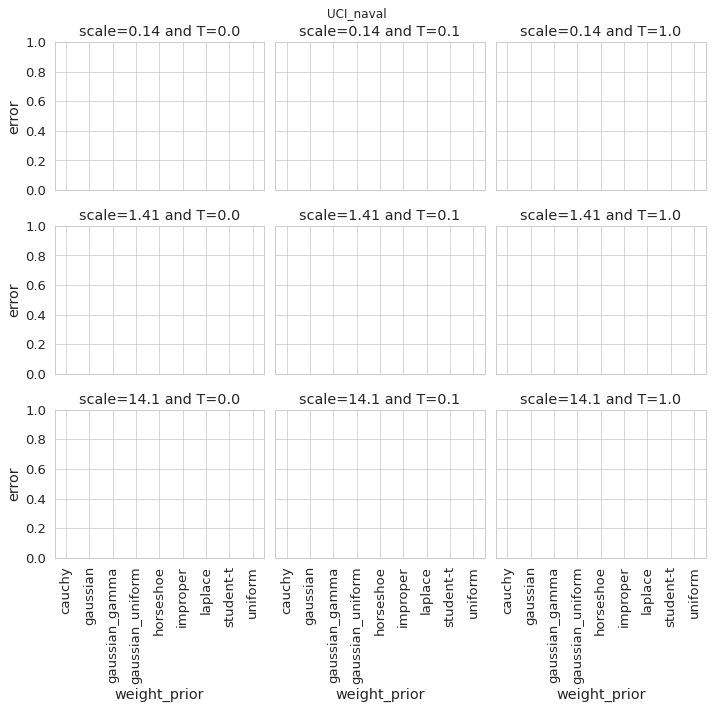

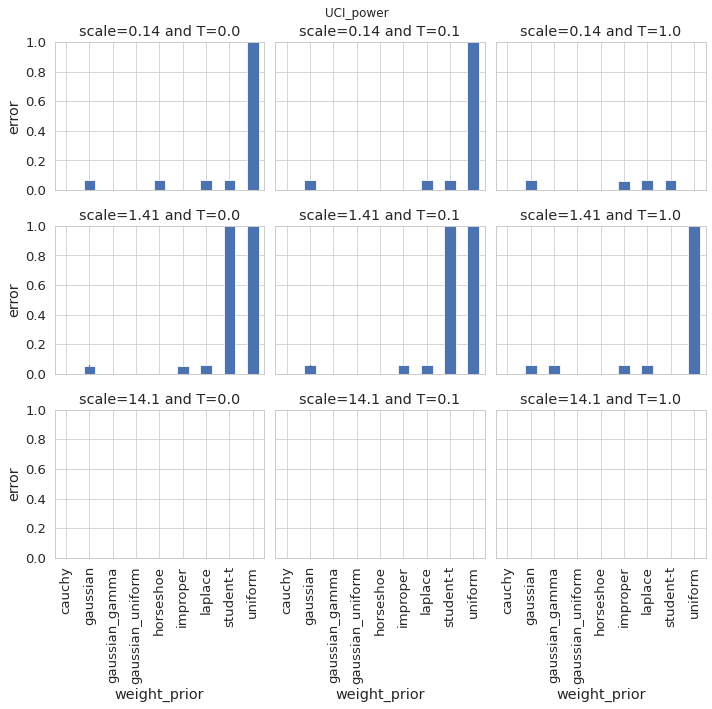

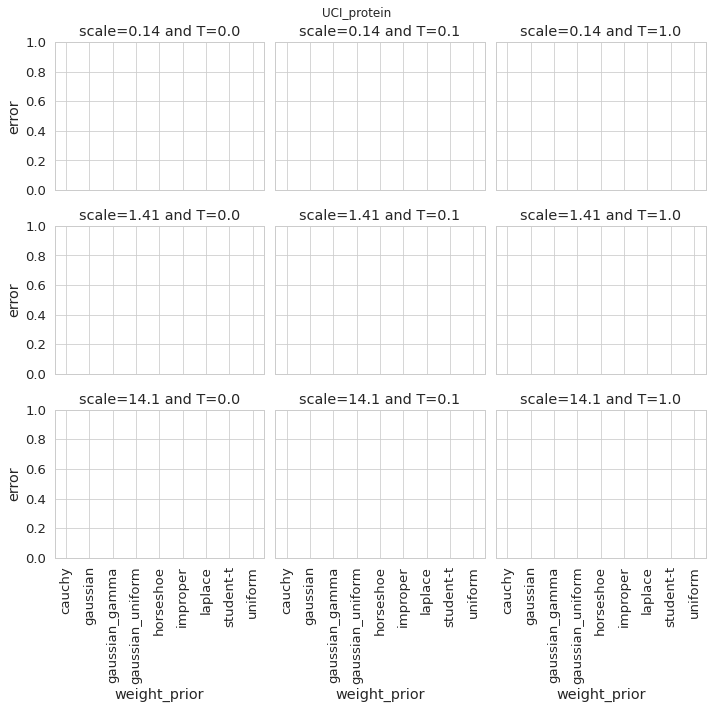

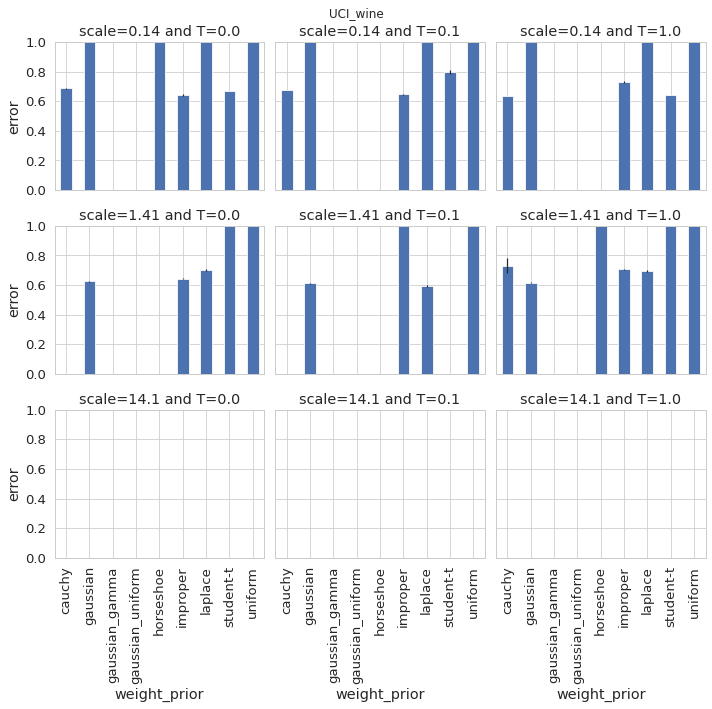

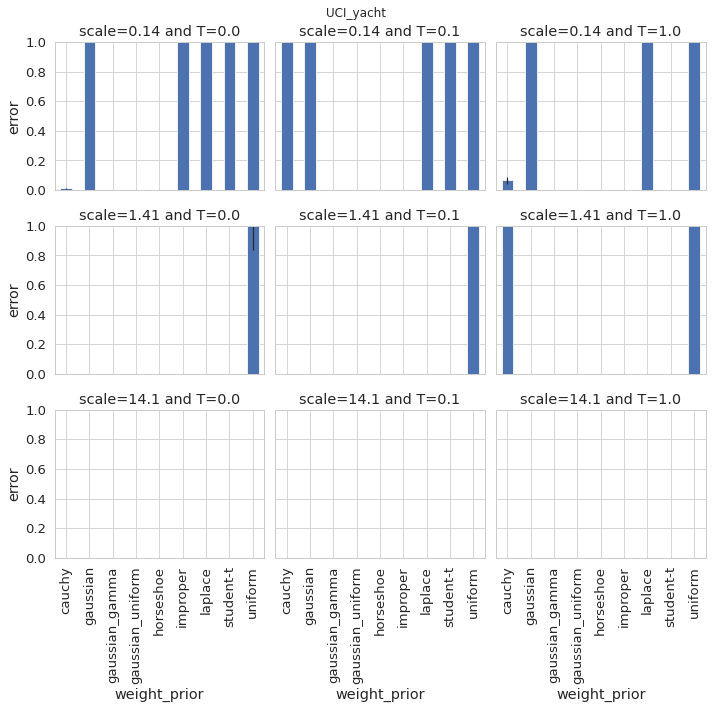

In [14]:
for dataset in datasets:
    runs_selected = runs_all.query(f"data == '{dataset}'")
    fig = plot_grid(runs_selected, y="acc_mean", yerr="acc_stderr", ylabel="error", ylim=(0.,1.), title=dataset)

In [13]:
fig.savefig(f"../figures/{exp_name}_acc.pdf")

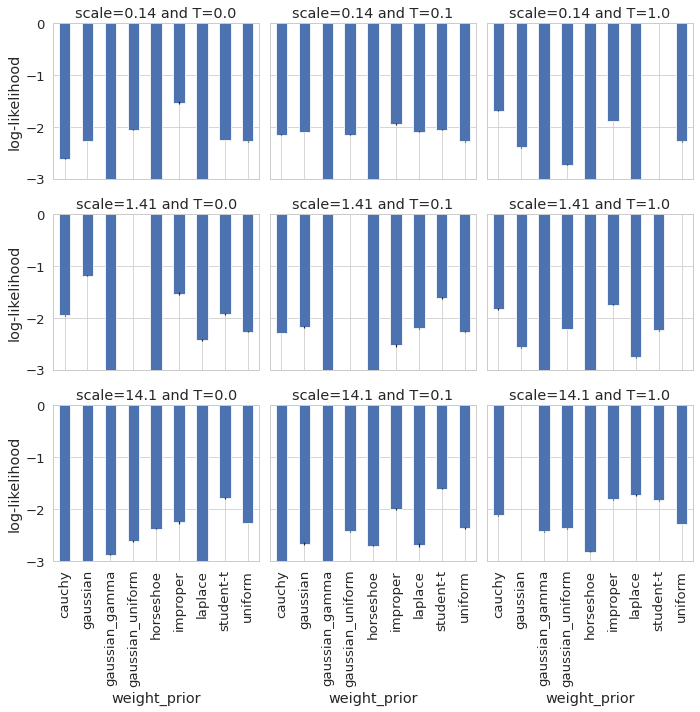

In [16]:
fig = plot_grid(runs_selected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-3., 0))

In [17]:
fig.savefig(f"../figures/{exp_name}_ll.pdf")

In [56]:
runs_selected = runs_all.query("eval_data == eval_data")

In [68]:
for col in runs_selected.columns:
    runs_selected[col] = runs_selected[col].astype(float, errors="ignore")

runs_selected = runs_selected.groupby(by=["weight_prior", "weight_scale", "temperature"]).mean()

runs_selected.reset_index(inplace=True)

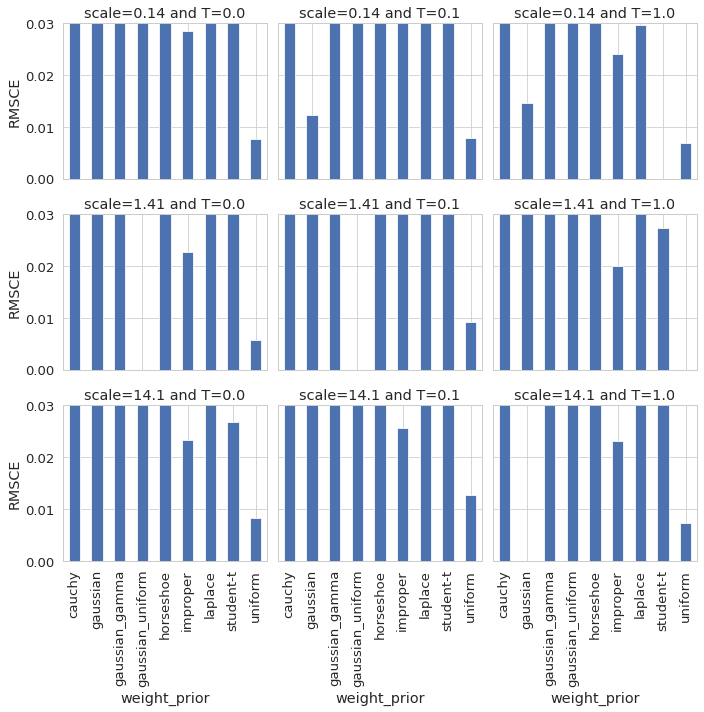

In [72]:
fig = plot_grid(runs_selected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.03))

In [73]:
fig.savefig(f"../figures/{exp_name}_rmsce.pdf")

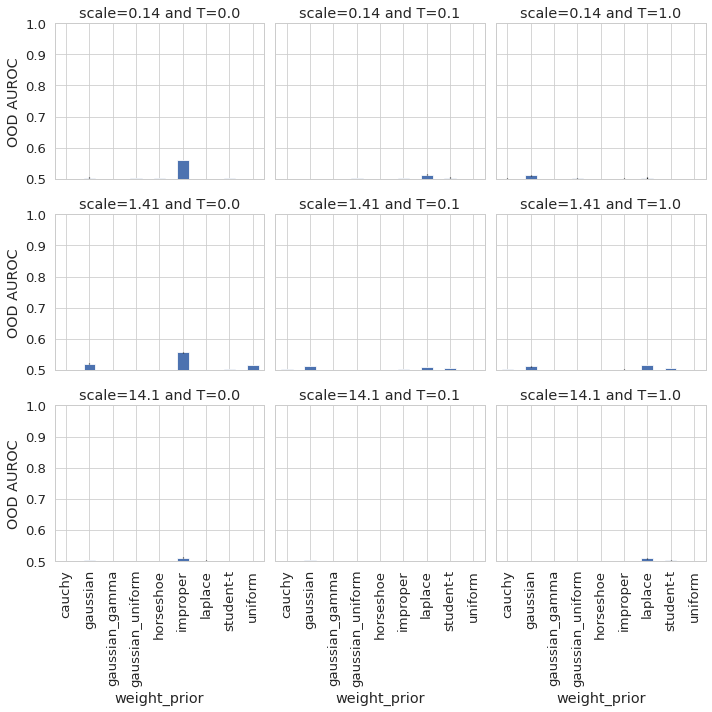

In [74]:
fig = plot_grid(runs_selected, y="auroc_mean", yerr="auroc_stderr", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [75]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")